In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## This project is for the configuration with time added as another node in the same neural network configuration (101->100)

In [5]:
import csv
df = pd.read_csv('quantum_harmonic_oscillator_timed_data.csv')
print("Dataset shape ", df.shape)

Dataset shape  (700000, 201)


1st column is time. The next 100 columns form initial data, and the final 100 forms the final data. For train-test split, we are taking the first 20% and last 20% rows (excluding the first column) to test and the middle 60% (excluding the first column) for training

In [6]:
df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,200
0,(0.1+0j),0j,0j,0j,0j,0j,0j,0j,0j,0j,...,(0.00465222022428247+0.0033526334529321994j),(-0.00034495909749273815+0.003069848615414131j),(-0.004259995963767665-0.0038234335990302744j),(0.001177316551006419-0.0019445722596893437j),(0.003756350776628675+0.003999164695726602j),(-0.0018372498146974647+0.000907622551506136j),(-0.0031845550717460843-0.00393779165241308j),(0.002330712915380679+2.3983443069842328e-06j),(0.0025835494228632744+0.0036981702771696537j),(-0.002670992805008735-0.0007646538609543808j)
1,(0.15918367346938775+0j),0j,0j,0j,0j,0j,0j,0j,0j,0j,...,(-0.002651222935125187-0.00859226056096798j),(0.005355540384200083-0.00257352593025725j),(0.001433248837256843+0.008096237130651938j),(-0.004798895282338713+0.0007665015901215265j),(-0.00048265883755909804-0.007423769596460699j),(0.0042397544074789925+0.0007206869278176746j),(-0.0002445911542137178+0.006615661747668711j),(-0.0036881020194072817-0.0019024421694058564j),(0.000785408660312358-0.0057234532968878475j),(0.0031577023437827315+0.002800600338871055j)
2,(0.21836734693877552+0j),0j,0j,0j,0j,0j,0j,0j,0j,0j,...,(-0.015398884102972151+0.010660288437832748j),(-0.008165151588281695-0.01197172872537453j),(0.012578812577664208-0.009359802553906177j),(0.006272160153075739+0.010181004500603403j),(-0.01062015412904054+0.0076945926536438995j),(-0.00438967867970076-0.009077357436999282j),(0.009159665759751346-0.006031155201926925j),(0.002732432653023457+0.008331966019316746j),(-0.007974721815458653+0.004507840400283664j),(-0.0013599432639618291-0.007751555414249552j)
3,(0.27755102040816326+0j),0j,0j,0j,0j,0j,0j,0j,0j,0j,...,(-0.024370218239200648+0.014178127181878587j),(-0.020291335093645432-0.018881984269167332j),(0.009416926765749801-0.02236021372152331j),(0.023884783449357107+0.005667414094509977j),(0.0009669935807697963+0.02202440438495841j),(-0.021953886186526984+0.002398177577845033j),(-0.0063344980729685835-0.018641512356110366j),(0.018544040498435055-0.006192990147553163j),(0.008213581057107582+0.014969616251232137j),(-0.01537323416635284+0.007355241047180702j)
4,(0.336734693877551+0j),0j,0j,0j,0j,0j,0j,0j,0j,0j,...,(-0.04119215726700725-0.09618791469208539j),(0.06482262261235745-0.06098567206406965j),(0.06923669710501981+0.03415616469718863j),(-0.007197789877300409+0.06146966204641338j),(-0.05078782261498225+0.011731996485263364j),(-0.022869537255575563-0.032905927011667856j),(0.01942590136731545-0.02767038284175j),(0.02656932906950866+0.003978418668062144j),(0.00451496116790165+0.02358210805101717j),(-0.017262162453766678+0.013637443343080676j)


In [7]:
marker_1 = int(0.2 * len(df))
marker_2 = int(0.8 * len(df))

# Split into training and testing data
train_data = df.iloc[marker_1:marker_2]
test_data = pd.concat([df.iloc[:marker_1], df.iloc[marker_2:]])

# Verifying shapes
print("Shape of train_data:", train_data.shape)
print("Shape of test_data:", test_data.shape)
print()

time = df.iloc[:,0]
print("time", time.shape)
# TRAINING DATA
feat_train = train_data.iloc[:, :101].values  # 1 to 101 columns are features
targ_train = train_data.iloc[:, 101:].values  # the next 100 columns are targets

# TESTING DATA
feat_test = test_data.iloc[:, :101].values
targ_test = test_data.iloc[:, 101:].values

# Verifying shapes after reshaping
print("Shape of feat_train:", feat_train.shape)
print("Shape of targ_train:", targ_train.shape)
print("Shape of feat_test:", feat_test.shape)
print("Shape of targ_test:", targ_test.shape)

Shape of train_data: (420000, 201)
Shape of test_data: (280000, 201)

time (700000,)
Shape of feat_train: (420000, 101)
Shape of targ_train: (420000, 100)
Shape of feat_test: (280000, 101)
Shape of targ_test: (280000, 100)


In [8]:
# Convert strings to complex numbers
F_train = np.vectorize(complex)(feat_train)
T_train = np.vectorize(complex)(targ_train)
F_test = np.vectorize(complex)(feat_test)
T_test= np.vectorize(complex)(targ_test)

In [9]:
# Convert numpy arrays to PyTorch tensors
F_train_tensor = torch.tensor(F_train, dtype = torch.complex64)
T_train_tensor = torch.tensor(T_train, dtype = torch.complex64)
F_test_tensor = torch.tensor(F_test, dtype = torch.complex64)
T_test_tensor = torch.tensor(T_test, dtype = torch.complex64)
print(F_train_tensor.shape)
print(F_train_tensor.dtype)

torch.Size([420000, 101])
torch.complex64


Defining a single block of the neural network that takes in 100 position + 1 time as input and predicts 100 positions.

In [10]:
torch.seed()

class SGDRegression(nn.Module):
    def __init__(self):
        super(SGDRegression, self).__init__()
        self.fc1 = nn.Linear(101, 400, dtype = torch.complex64)  # Input layer [1 input]
        self.fc2 = nn.Linear(400, 50,  dtype = torch.complex64)  # Hidden layer 1
        self.fc3 = nn.Linear(50, 400,  dtype = torch.complex64)  # Hidden layer 2
        self.fc4 = nn.Linear(400, 100,  dtype = torch.complex64)   # Output layer [1 output]

    def forward(self, x):
        x = torch.tanh(self.fc1(x))  
        x = torch.tanh(self.fc2(x)) 
        x = torch.tanh(self.fc3(x))  
        x = self.fc4(x)
        return x

Loss function: Since we have complex numbers, we use conjugates to calculate the mean squared error loss

In [11]:
class CustomLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, data_preds, data_targs):
        # data loss
        diff = data_preds - data_targs
        diff_dag = torch.conj(diff)
        loss_data = torch.mean(diff*diff_dag)
        return loss_data.float()

Within the training loop, we implement mini-batch gradient descent.

In [16]:
#from tensorboardX import SummaryWriter
BATCH_SIZE = 16
EPOCHS = 5
LR = 0.001

train_data = torch.utils.data.TensorDataset(F_train_tensor, T_train_tensor)
data_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

size = len(data_loader.dataset)
model = SGDRegression()
loss_fn = CustomLoss() 
alpha = 0.5
optimizer = optim.Adam(model.parameters(), lr=LR)
losses = []
    
for epoch in range(EPOCHS):
    for batch, (input_data, output_data) in enumerate(data_loader):

        pred = model(input_data)
        loss = loss_fn(pred, output_data)
        losses.append(loss.item())
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()        
        
print("Done")
#i and r instead of x and y

Done


Graphing the loss function

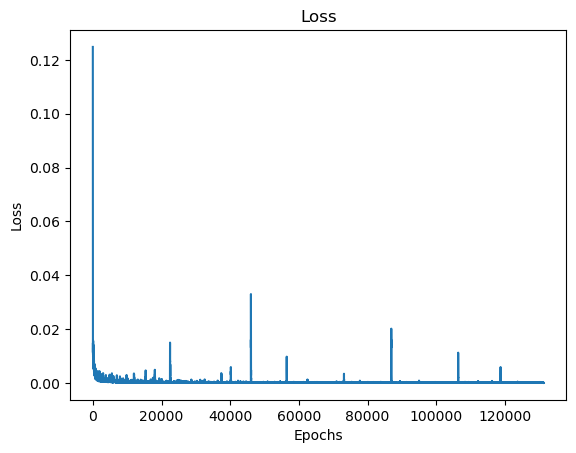

In [17]:
EPOCHS = list(range(1, len(losses) + 1))
plt.plot(EPOCHS, losses)
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

Model Evaluation: Here, we randomly sample num_samples number of distributions from the testing data and plot it to view performance of the model.

(2.940816326530612+0j)
(2.1714285714285713+0j)
(1.8755102040816325+0j)
(0.6326530612244897+0j)
(1.2244897959183674+0j)


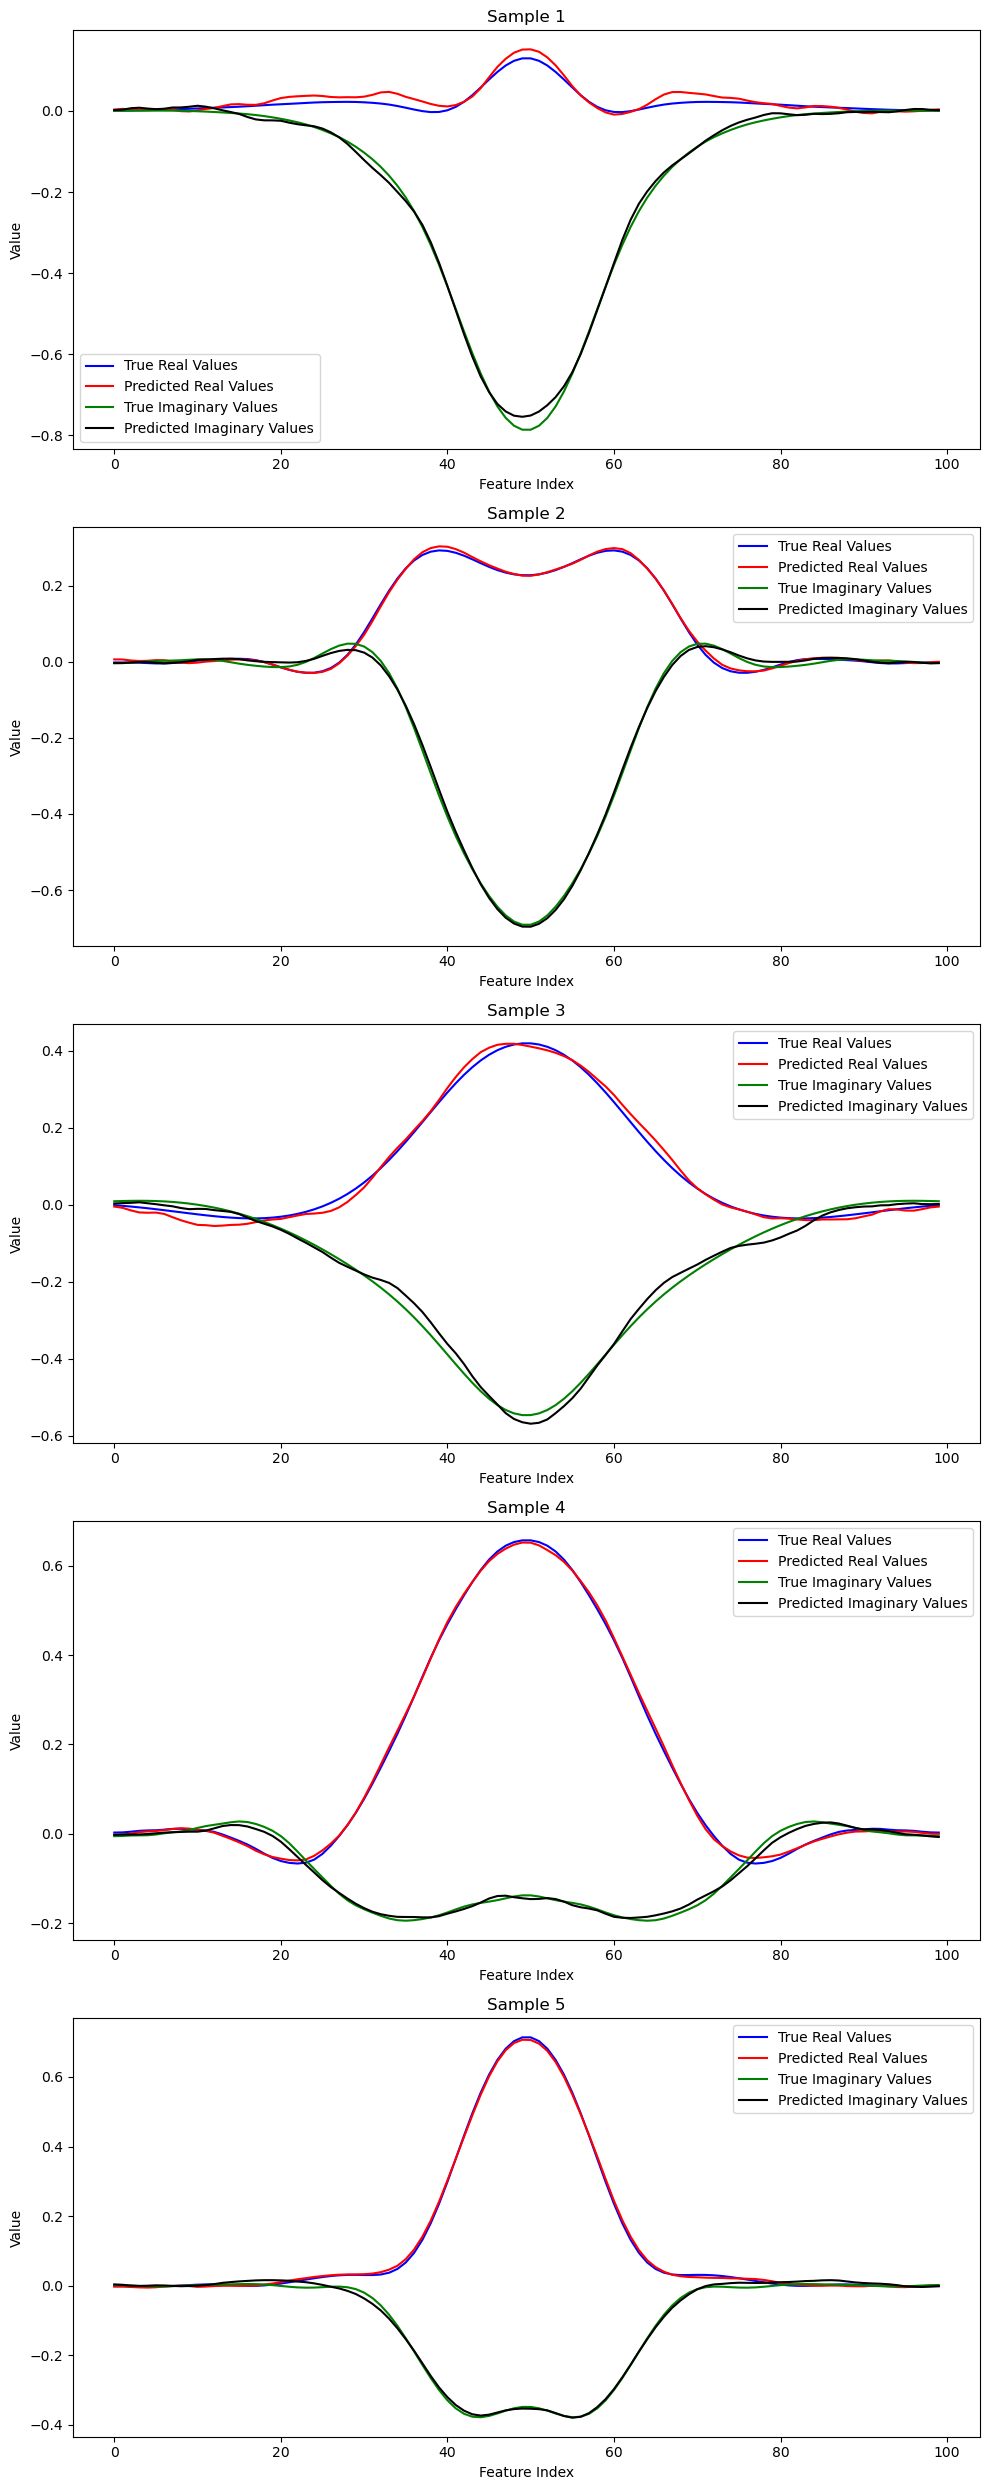

In [21]:
# Randomly select a subset of the test data
#Evaluating
model.eval()
with torch.no_grad():
    test_pred = model(F_test_tensor)
test_pred = test_pred.numpy()

num_samples = 5  # Number of samples to plot
indices = np.random.choice(F_test_tensor.shape[0], num_samples)
for i in indices:
    print(time[i])
# Get the true and predicted values for these indices
true_values = T_test_tensor[indices].numpy()
predicted_values = test_pred[indices]

# Plotting the results
fig, axs = plt.subplots(num_samples, 1, figsize=(10, 5 * num_samples))

for i in range(num_samples):
    axs[i].plot(range(100), true_values[i], color='blue', label='True Real Values')
    axs[i].plot(range(100), predicted_values[i], color='red', label='Predicted Real Values')
    axs[i].plot(range(100), true_values[i].imag, color='green', label='True Imaginary Values')
    axs[i].plot(range(100), predicted_values[i].imag, color='black', label='Predicted Imaginary Values')
    axs[i].set_title(f'Sample {i+1}')
    axs[i].set_xlabel('Feature Index')
    axs[i].set_ylabel('Value')
    axs[i].legend()

plt.tight_layout()
plt.show()

### check the samples with largest loss and check for trends

In [ ]:
num = F_train_tensor.shape[0]
losses = np.zeros(num)

#Evaluating
model.eval()
with torch.no_grad():
    train_pred = model(F_train_tensor)
train_pred = train_pred.numpy()

for i in range(num):
    predicted = train_pred[i]
    actual = T_train_tensor[i].numpy()
    diff = predicted - actual
    diff_conj = np.conjugate(diff)
    loss = (1 / 100) * np.sum(diff * diff_conj)
    losses[i] = loss


# Plotting the histogram of losses
plt.hist(losses, bins=1000, edgecolor='black')
plt.title('Histogram of Losses on Test Data')
plt.xlabel('Testing Loss')
plt.ylabel('Frequency')
plt.show()
